In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras import models
from keras.optimizers import RMSprop, Adam

%matplotlib inline

In [80]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")

In [82]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
# df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

## Add a continent feature

In [83]:
# Changing the conuntry names as required by pycountry_convert Lib
for ds in [df_confirmed, df_deaths, df_covid19]:
    ds.loc[ds['country'] == "US", "country"] = "USA"
    ds.loc[ds['country'] == "Korea, South", "country"] = "South Korea"
    ds.loc[ds['country'] == "Taiwan*", "country"] = "Taiwan"
    ds.loc[ds['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
    ds.loc[ds['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
    ds.loc[ds['country'] == "Reunion", "country"] = "Réunion"
    ds.loc[ds['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
    ds.loc[ds['country'] == "Bahamas, The", "country"] = "Bahamas"
    ds.loc[ds['country'] == "Gambia, The", "country"] = "Gambia"

# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])

# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return continents[pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))]
    except :
        return continents['na']

#Collecting Continent Information
df_confirmed.insert(2,"continent", df_confirmed["country"].map(country_to_continent_code))
df_deaths.insert(2,"continent",  df_deaths["country"].map(country_to_continent_code))
df_covid19.insert(1,"continent",  df_covid19["country"].map(country_to_continent_code))

## Remove NULL values

In [86]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

In [88]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')

    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]

    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")")

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[0]+" "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days

In [106]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)

# Add an index column
df_countries_cases.index = df_countries_cases["country"] 

# remove the original index column
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

## Style background_gradient

In [107]:
pd.DataFrame(df_countries_cases.sum()).transpose().style.background_gradient(cmap='Wistia',axis=1)

In [120]:
df_continents_cases.style.background_gradient(cmap='Wistia')

In [124]:
df_countries_cases.sort_values('Confirmed', ascending=False).head(10)

Confirmed  Deaths  Recovered  Active
country                                             
USA                104839    1711        894       0
Italy               86498    9134      10950   66414
China               81946    3299      75098    3549
Spain               65719    5138       9357   51224
Germany             50871     351       6658   43862
France              33414    1997       5707   25710
Iran                32332    2378      11133   18821
United Kingdom      14751     761        151   13839
Switzerland         12928     231       1530   11167
South Korea          9478     144       4811    4523

## Horizontal bar

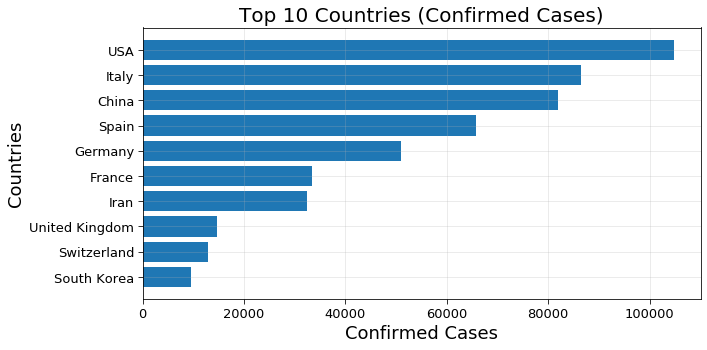

In [153]:
f = plt.figure(figsize=(10, 5))
f.add_subplot(111)

plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-10:], df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-10:],)
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.ylabel("Countries",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig('Top 10 Countries (Confirmed Cases).png')

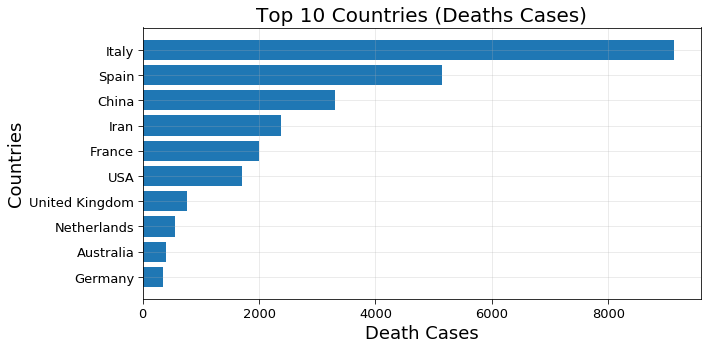

In [155]:
f = plt.figure(figsize=(10, 5))
f.add_subplot(111)

plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:], df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],)
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Death Cases",fontsize=18)
plt.ylabel("Countries",fontsize=18)
plt.title("Top 10 Countries (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig('Top 10 Countries (Death Cases).png')

## Correlation analysis

In [157]:
df_countries_cases.corr().style.background_gradient(cmap='Reds')

In [158]:
df_continents_cases.corr().style.background_gradient(cmap='Reds')

## Visualization map

In [159]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['country']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['state']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(world_map)

world_map

## Global confirmed cases heatmap

In [160]:
temp_df = pd.DataFrame(df_countries_cases['Confirmed'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df.iloc[:,-1]), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Cases Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Reds")
# fig.to_image("Global Heat Map confirmed.png")
fig.show()

## Global Deaths Heat Map

In [161]:
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df.iloc[:,-1]+1), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Cases Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Reds")
# fig.to_image("Global Heat Map deaths.png")
fig.show()

## Number of countries affected

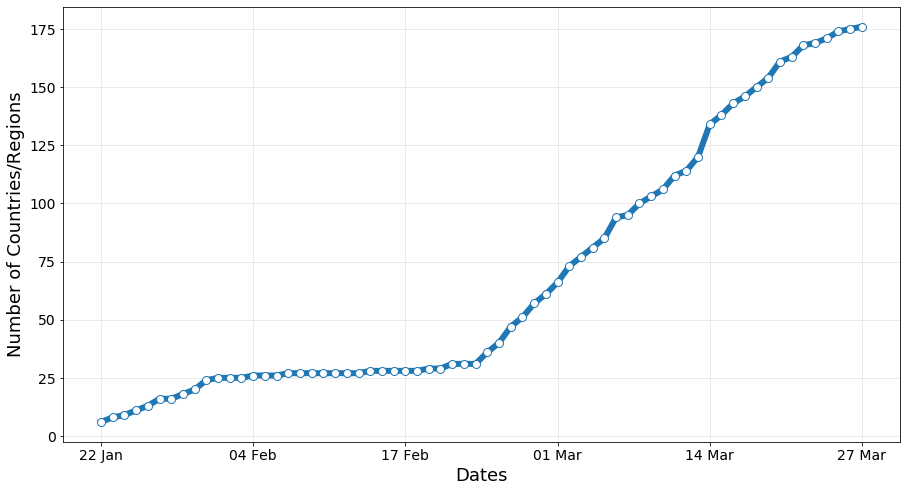

In [162]:
case_nums_country = df_confirmed.groupby("country").sum().drop(['Lat','Long'],axis =1).apply(lambda x: x[x > 0].count(), axis =0)
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in case_nums_country.index]

f = plt.figure(figsize=(15,8))
f.add_subplot(111)

marker_style = dict(linewidth=6, linestyle='-', marker='o',markersize=8, markerfacecolor='#ffffff')
plt.plot(d, case_nums_country,**marker_style)
plt.tick_params(labelsize = 14)
plt.xticks(list(np.arange(0,len(d),int(len(d)/5))),d[:-1:int(len(d)/5)]+[d[-1]])

#labels
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Number of Countries/Regions",fontsize=18)
plt.grid(alpha = 0.3)
plt.savefig('spread.png')

## COVID-19 Global Spread Trends

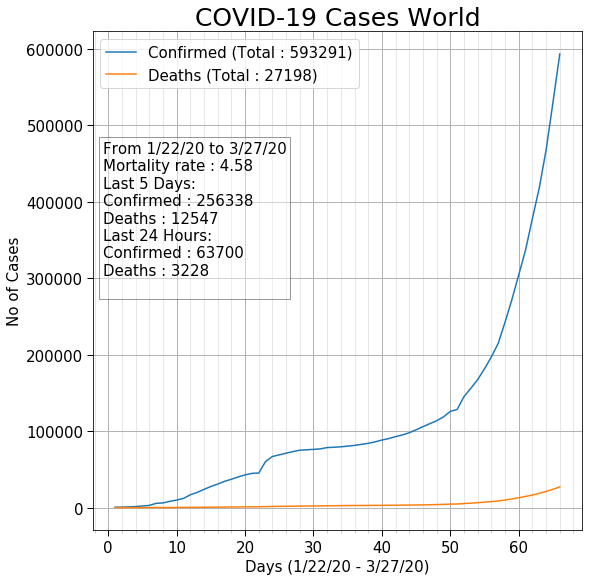

In [163]:
cols = 1
rows = 1
f = plt.figure(figsize=(10,10*rows))
visualize_covid_cases(df_confirmed, df_deaths,continent = "All",figure = [f,rows,cols, 1])

plt.savefig('COIVD-19-World.png')

plt.show()

## COVID-19 Spread Trends in Different Continents

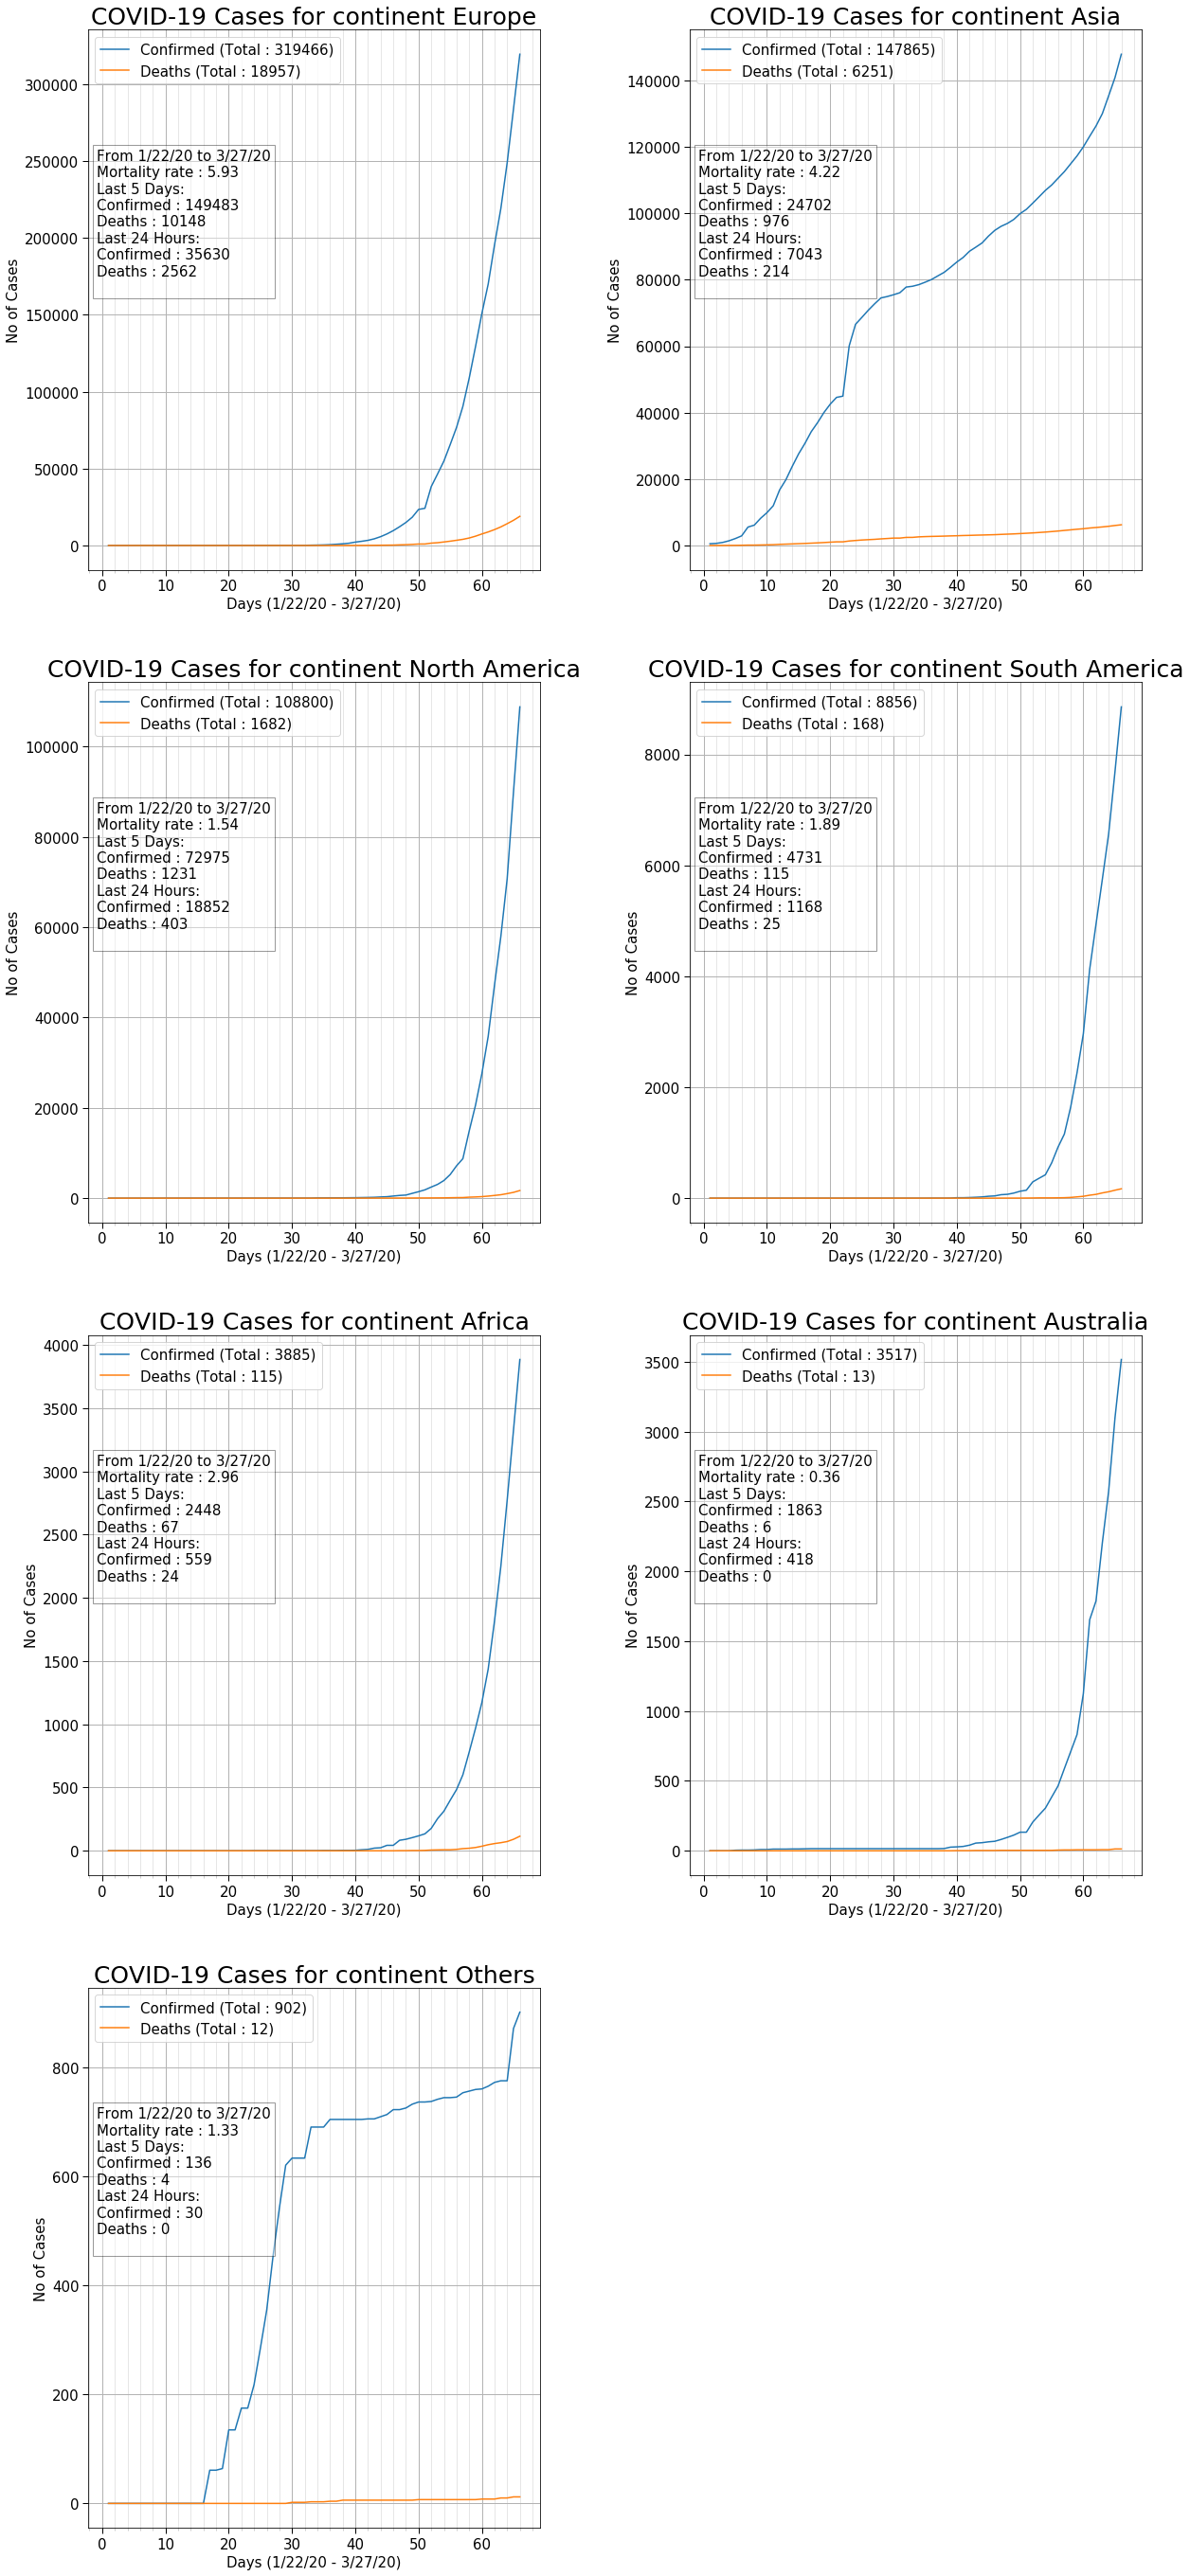

In [164]:
df_continents= df_confirmed.groupby(["continent"]).sum()
continents = df_continents.sort_values(df_continents.columns[-1],ascending = False).index

cols =2
rows = int(np.ceil(continents.shape[0]/cols))
f = plt.figure(figsize=(20,10*rows))
for i,continent in enumerate(continents):
    visualize_covid_cases(df_confirmed, df_deaths, continent = continent,figure = [f,rows,cols, i+1])

plt.show()

## COVID-19 Spread Trends in Few Most Affected Countries

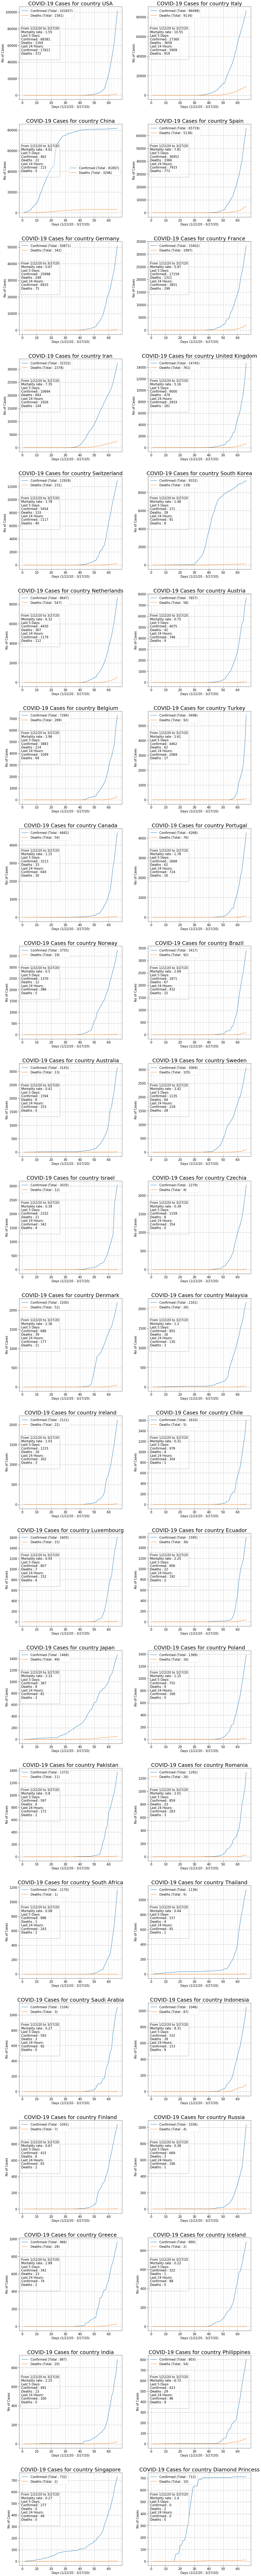

In [165]:
df_countries = df_confirmed.groupby(["country"]).sum()
df_countries = df_countries.sort_values(df_countries.columns[-1],ascending = False)
countries = df_countries[df_countries[df_countries.columns[-1]] >= 700].index

cols =2
rows = int(np.ceil(countries.shape[0]/cols))
f = plt.figure(figsize=(20,8*rows))
for i,country in enumerate(countries):
    visualize_covid_cases(df_confirmed, df_deaths,country = country,figure = [f,rows,cols, i+1])

plt.show()

## COVID-19 Spread Comparison of few most affected countries and INDIA

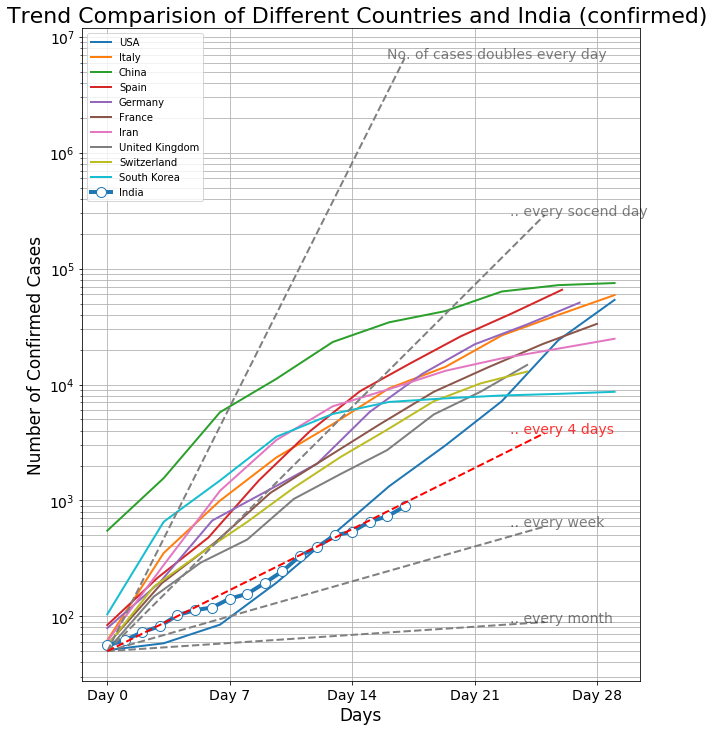

In [166]:
temp = df_confirmed.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed.columns[-1], ascending= False)

threshold = 50
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i >= 10:
        if country != "India":
            continue
    x = 30
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:x]
     
    date = np.arange(0,len(t[:x]))
    xnew = np.linspace(date.min(), date.max(), 10)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    if country != "India":
        plt.plot(xnew,power_smooth,label = country,linewidth =2)
    else:
        marker_style = dict(linewidth=4, linestyle='-', marker='o',markersize=10, markerfacecolor='#ffffff')
        plt.plot(date,t,"-.",label = country,**marker_style)

plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,30,7),[ "Day "+str(i) for i in range(30)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every socend day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)


# India is following trend similar to doulbe the cases in 4 days but it may increase the rate 
x = np.arange(0,26)
y = 2**(x/4+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "Red")
plt.annotate(".. every 4 days",(x[-3],y[-1]),color="Red",xycoords="data",fontsize=14,alpha = 0.8)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("Trend Comparision of Different Countries and India (confirmed) ",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig('Trend Comparision with India (confirmed).png')
plt.show()

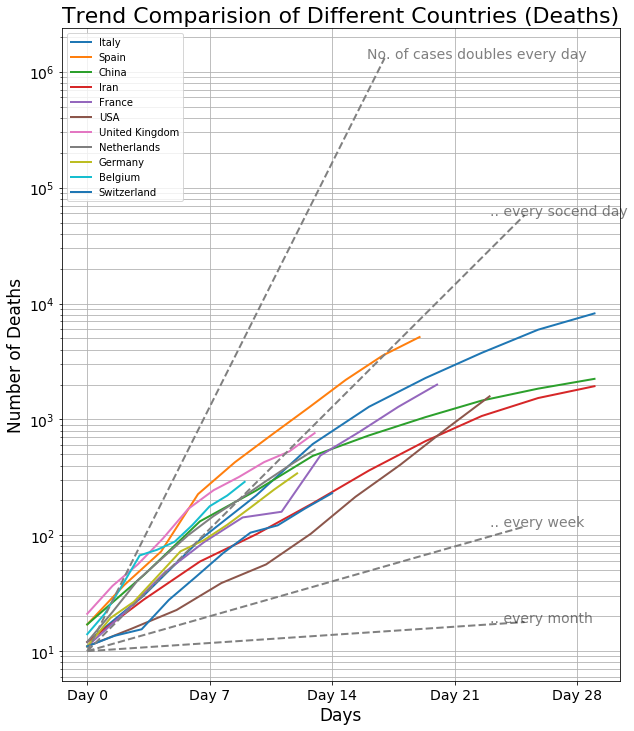

In [167]:
temp = df_deaths.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed.columns[-1], ascending= False)

threshold = 10
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i > 10:
        break
    x = 30
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:x]
     
    date = np.arange(0,len(t[:x]))
    xnew = np.linspace(date.min(), date.max(), 10)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,label = country,linewidth =2)


plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,30,7),[ "Day "+str(i) for i in range(30)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every socend day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Deaths",fontsize=17)
plt.title("Trend Comparision of Different Countries (Deaths)",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig('Trend Comparision with India.png')
plt.show()

## Global Trend

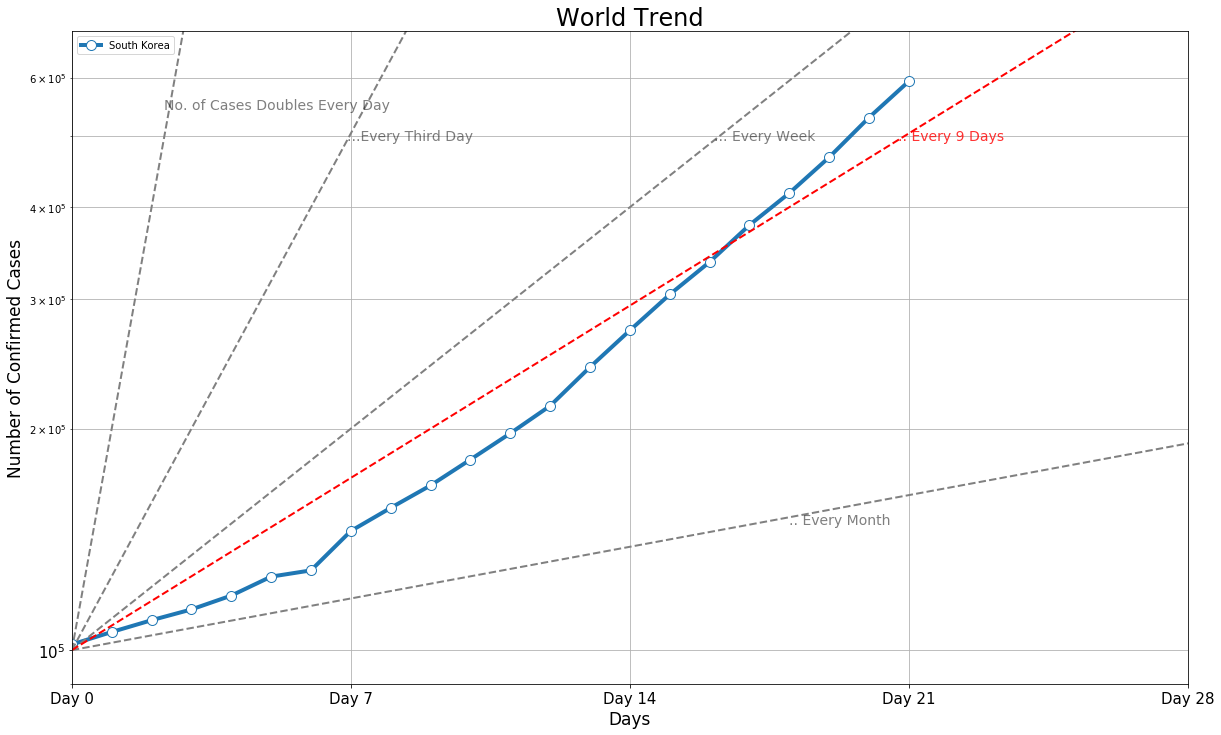

In [168]:
temp_data = df_confirmed.iloc[:,5:].sum(axis =0)
f = plt.figure(figsize=(20,12))
f.add_subplot(111)

threshold = 100000

t = temp_data.values
t = t[t >threshold]

date = np.arange(0,len(t[:]))
xnew = np.linspace(date.min(), date.max(), 10)
spl = make_interp_spline(date, t, k=1)  # type: BSpline
power_smooth = spl(xnew)

marker_style = dict(linewidth=4, linestyle='-', marker='o',markersize=10, markerfacecolor='#ffffff')
plt.plot(date,t,"-.",label = country,**marker_style)


# Reference lines 
x = np.arange(0,32)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of Cases Doubles Every Day",(np.log2((t.max()-threshold)/threshold),t.max()-threshold/2),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,32)
y = 2**(x/3+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("...Every Third Day",(np.log2((t.max()-threshold)/threshold)*3,t.max()-threshold),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,32)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("... Every Week",(np.log2((t.max()-threshold)/threshold)*7,t.max()-threshold),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,32)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. Every Month",(18,2**(17/30+np.log2(threshold))),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,32)
y = 2**(x/9+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "Red")
plt.annotate(".. Every 9 Days",(np.log2((t.max()-threshold)/threshold)*9,t.max()-threshold),color="Red",xycoords="data",fontsize=14,alpha = 0.8)


plt.xlim(date[0],date[-1])
plt.ylim(threshold - threshold/10,t.max()+threshold)
# plot Params
# plt.tight_layout()
plt.tick_params(labelsize = 15)        
plt.xticks(np.arange(0,len(t[:])+7,7),[ "Day "+str(i) for i in range(len(t[:])+7)][::7]) 
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("World Trend",fontsize=24)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.show()

## Prediction Curve for Global Confirmed Cases

In [169]:
model = models.load_model("model_confirmed.h5")
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 1)                 81        
_________________________________________________________________
Output (LeakyReLU)           (None, 1)                 0  

In [171]:
data_y = np.log10(np.asarray(df_confirmed.sum()[5:]).astype("float32"))
data_x = np.arange(1,len(data_y)+1)

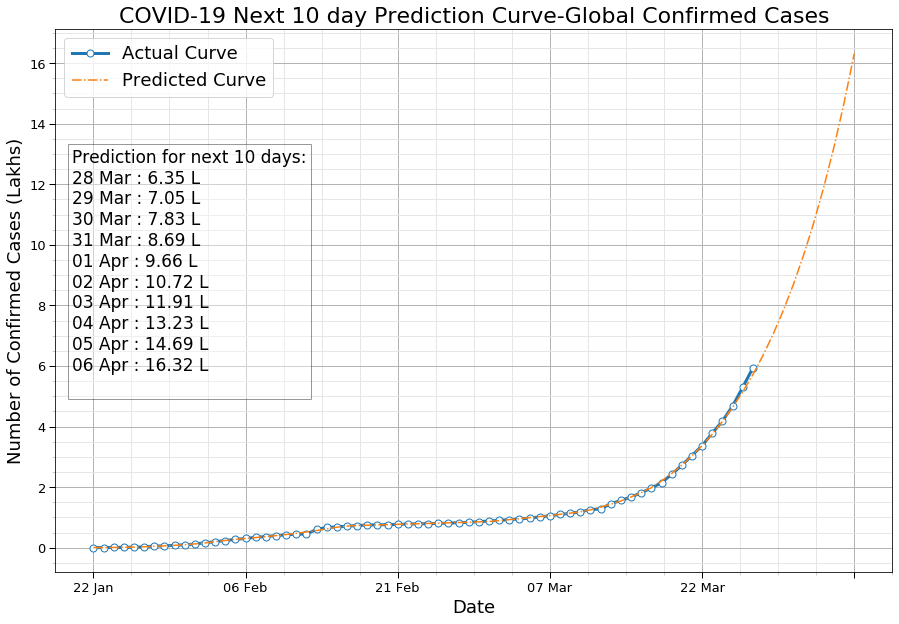

In [172]:
lakh = 100000
prediction_days = 10
data = np.power(10,model.predict(np.arange(1,len(data_y)+prediction_days+1)))
temp_data = df_confirmed.iloc[:,5:].sum(axis =0)
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)

date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=7, markerfacecolor='#ffffff')
plt.plot(date,temp_data/lakh,"-.",**marker_style, label="Actual Curve")

date = np.arange(0,len(data))
plt.plot(date,data/lakh,"-.",label="Predicted Curve")

next5 = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
d += next5

text = "Prediction for next "+str(prediction_days) +" days:\n"
for i in range(prediction_days):
    text += next5[i]+" : "+str(np.round(data[-1*(prediction_days-i)],-3)[0]/lakh)+" L\n"

plt.text(0.02, 0.78, text, fontsize=17, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))

# X-axis
plt.xticks(list(np.arange(0,len(d),int(len(d)/5))),d[:-1:int(len(d)/5)])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

# Plot Title
plt.title("COVID-19 Next 10 day Prediction Curve-Global Confirmed Cases",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Confirmed Cases (Lakhs)",fontsize =18)

# plt.yscale("log")
plt.legend(fontsize =18)
plt.tick_params(labelsize = 13) 
plt.savefig("Prediction Curve-Confirmed.png")
plt.show()

## Prediction Curve for Global Death Cases

In [173]:
data1_y = np.log10(np.asarray(df_deaths.sum()[5:-1]).astype("float32"))
data1_x = np.arange(1,len(data_y))

In [174]:
model2 = models.load_model("model_deaths.h5")
model2.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 1)                 81        
_________________________________________________________________
Output (LeakyReLU)           (None, 1)                 0  

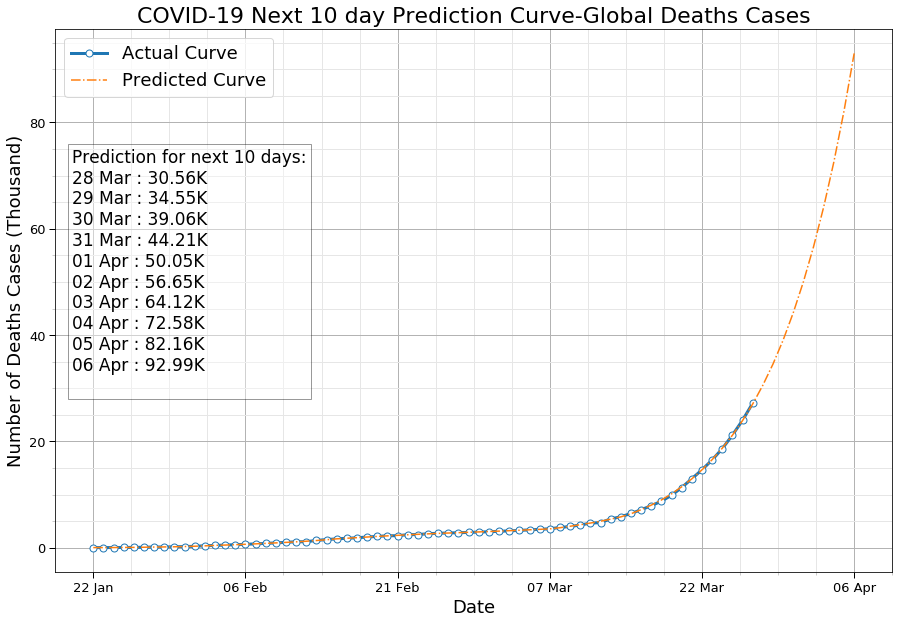

In [175]:
thousand = 1000
prediction_days = 10
data = np.power(10,model2.predict(np.arange(1,len(data_y)+prediction_days+1)))
temp_data = df_deaths.iloc[:,5:].sum(axis =0)
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))
# xnew = np.linspace(date.min(), date.max(), 10)
# spl = make_interp_spline(date, t, k=1)  # type: BSpline
# power_smooth = spl(xnew)

marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=7, markerfacecolor='#ffffff')
plt.plot(date,temp_data/thousand,"-.",**marker_style, label="Actual Curve")


date = np.arange(0,len(data))
plt.plot(date,data/thousand,"-.",label="Predicted Curve")

text = "Prediction for next "+str(prediction_days) +" days:\n"
for i in range(prediction_days):
    text += next5[i]+" : "+str(np.round(data[-1*(prediction_days-i)],-1)[0]/thousand)+"K\n"

plt.text(0.02, 0.78, text, fontsize=17, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))

# X-axis
plt.xticks(list(np.arange(0,len(d),int(len(d)/5))),d[:-1:int(len(d)/5)]+[d[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=12)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

# Plot Title
plt.title("COVID-19 Next 10 day Prediction Curve-Global Deaths Cases",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Deaths Cases (Thousand)",fontsize =18)

# plt.yscale("log")
plt.legend(fontsize =18)
plt.tick_params(labelsize = 13) 
plt.savefig("Prediction Curve2.png")
plt.show()

## COVID-19 Case (Confirmed and Deaths) Percent Split in Different countries (Pie Viz)

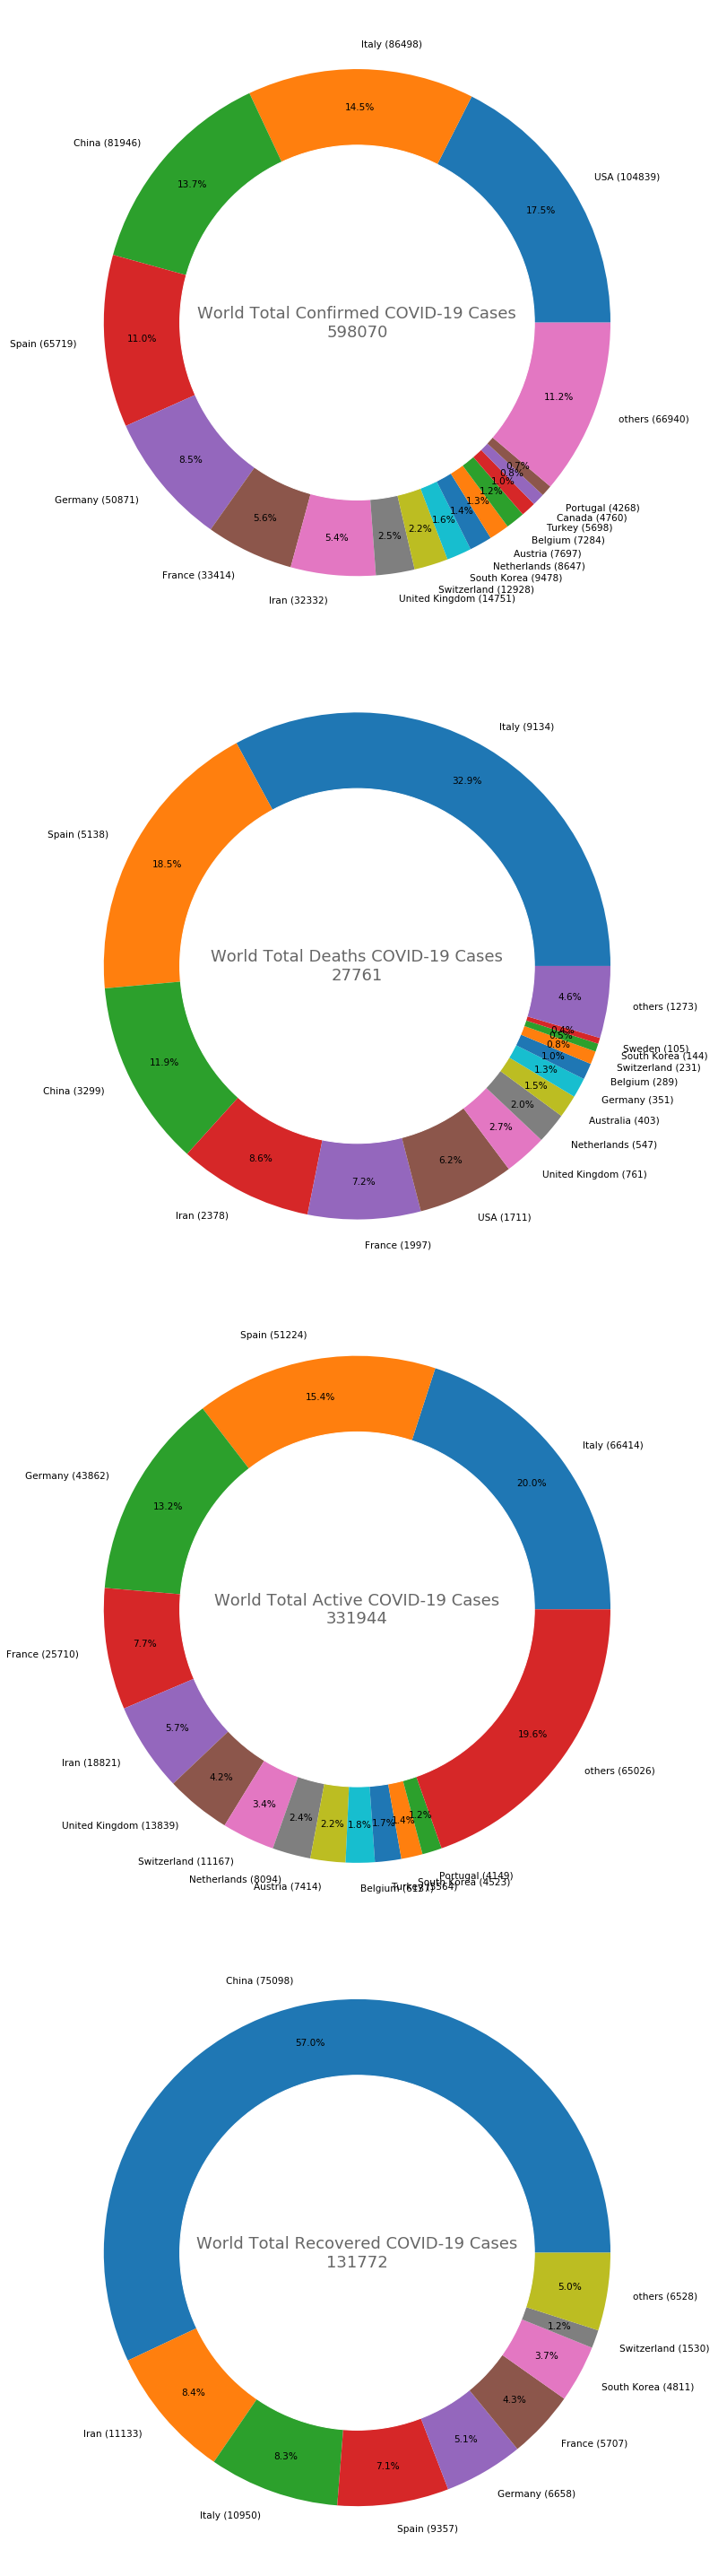

In [176]:
rows = 4
f = plt.figure(figsize=(15,10*rows))

stats = [df_covid19.loc[:,['country','Confirmed']],df_covid19.loc[:,['country','Deaths']],df_covid19.loc[:,['country','Active']],df_covid19.loc[:,['country','Recovered']]]
label = ["Confirmed","Deaths","Active","Recovered"]
threshold = [4000,100,4000,1000]
for i, stat in enumerate(stats):
    plt.tight_layout()
    df_countries = stat.groupby(["country"]).sum()
    df_countries = df_countries.sort_values(df_countries.columns[-1],ascending= False)
    others = df_countries[df_countries[df_countries.columns[-1]] < threshold[i] ].sum()[-1]
    df_countries = df_countries[df_countries[df_countries.columns[-1]] > threshold[i]]
    df_countries = df_countries[df_countries.columns[-1]]
    df_countries["others"] = others
    labels = [df_countries.index[i] +" (" + str(int(df_countries[i])) +") "for i in range(df_countries.shape[0])]

    ax = f.add_subplot(rows,1,i+1)
    plt.pie(df_countries, labels=labels,autopct='%1.1f%%',pctdistance=0.85, labeldistance=1.1,textprops = {'fontsize':10.5})
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.text(0.5,0.5,"World Total "+label[i]+ " COVID-19 Cases\n"+str(stat.sum().values[1]), horizontalalignment='center',verticalalignment='center',transform=ax.transAxes, size=18, alpha = 0.6)


plt.show()


## COVID-19 Mortality Rate Variation Over Period of Time

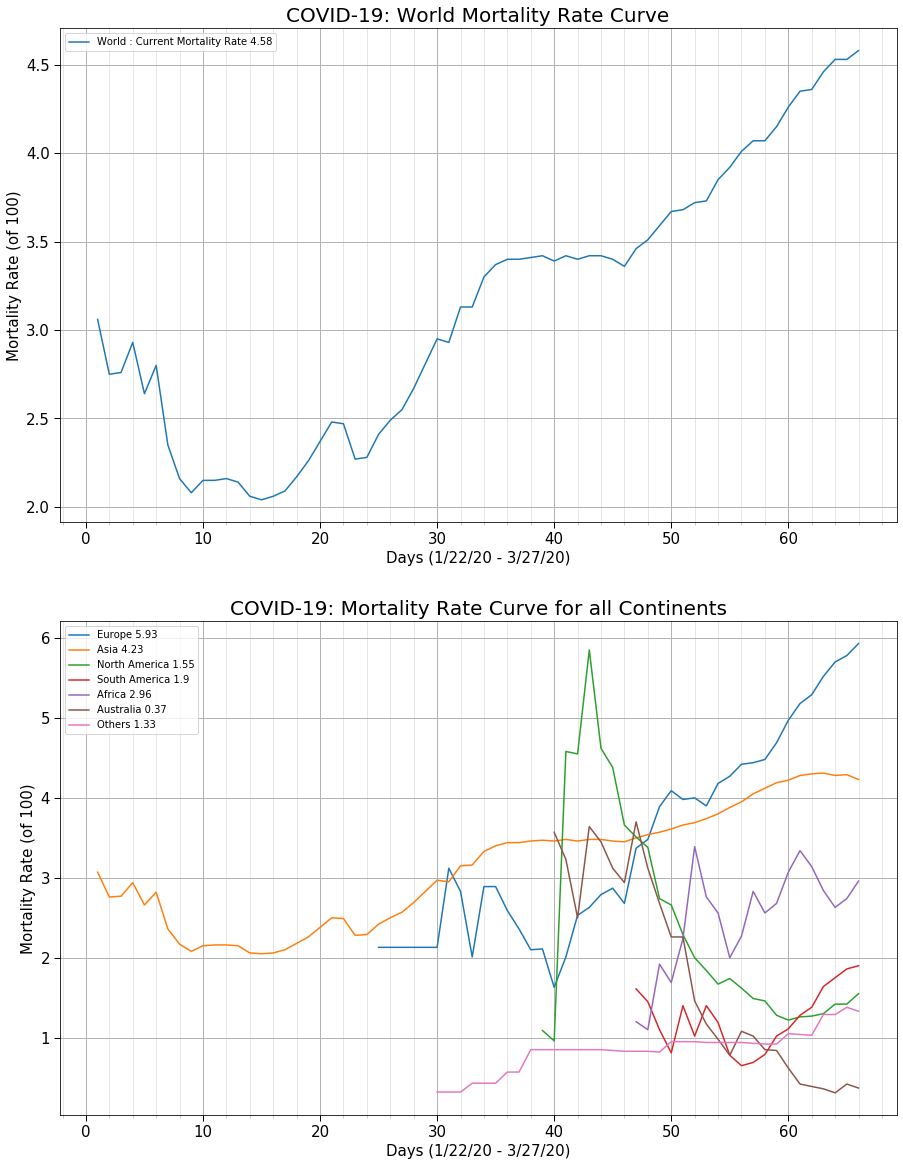

In [177]:
df_continents= df_confirmed.groupby(["continent"]).sum()
continents = df_continents.sort_values(df_continents.columns[-1],ascending = False).index
continents = ["All"]+list(continents)

cols =1
rows = 2
axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","Mortality Rate (of 100)"]

f = plt.figure(figsize=(15,10*rows))

#SubPlot 1
ax = f.add_subplot(211)
mortality_rate = get_mortality_rate(df_confirmed,df_deaths,continent=continents[0])
plt.plot(np.arange(1,mortality_rate.shape[0]+1),mortality_rate,label = "World : Current Mortality Rate "+str(mortality_rate[-1]))

plt_title = "COVID-19: World Mortality Rate Curve"
plot_params(ax,axis_label,plt_title)
# Legend Location
l = plt.legend(loc= "best")


#SubPlot 2
ax = f.add_subplot(212)
for i, continent in enumerate(continents[1:]):
    mortality_rate = get_mortality_rate(df_confirmed,df_deaths,continent=continent)
    plt.plot(np.arange(1+mortality_rate[mortality_rate == 0].shape[0],mortality_rate[mortality_rate == 0].shape[0]+mortality_rate[mortality_rate > 0].shape[0]+1),mortality_rate[mortality_rate > 0],label = continents[i+1]+" "+str(mortality_rate[-1]))

plt_title = "COVID-19: Mortality Rate Curve for all Continents"
plot_params(ax,axis_label,plt_title)

# Legend Location
l = plt.legend(loc= "best")

plt.savefig('Mortality rate.png')
plt.show()


## Comparision of Mortality and Recovery Rate

## Cumulative Confirmed Cases and Cumulative Recovery Vs Cumulative Deaths Analysis

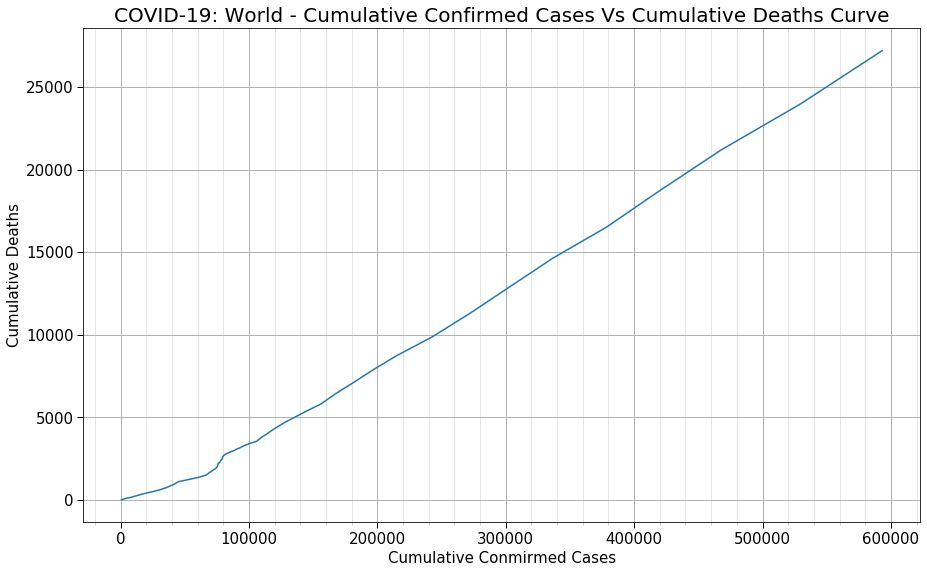

In [178]:
cols =1
rows = 2

f = plt.figure(figsize=(15,10*rows))

# SubPlot 1
ax = f.add_subplot(211)
plt.plot(np.sum(np.asarray(df_confirmed.iloc[:,5:]),axis = 0),np.sum(np.asarray(df_deaths.iloc[:,5:]),axis = 0))

axis_label = ["Cumulative Conmirmed Cases","Cumulative Deaths"]
plt_title = "COVID-19: World - Cumulative Confirmed Cases Vs Cumulative Deaths Curve"
plot_params(ax,axis_label,plt_title)


# # SubPlot 2
# ax = f.add_subplot(212)
# mortality_rate = get_mortality_rate(df_confirmed,df_deaths,continent=continents[0])
# plt.plot(np.sum(np.asarray(df_recovered.iloc[:,5:]),axis = 0),np.sum(np.asarray(df_deaths.iloc[:,5:]),axis = 0))

# axis_label = ["Cumulative Recoveries","Cumulative Deaths"]
# plt_title = "COVID-19: World - Cumulative Recovery Vs Cumulative Deaths Curve"

# plot_params(ax,axis_label,plt_title)
plt.show()

## China Vs Outside China

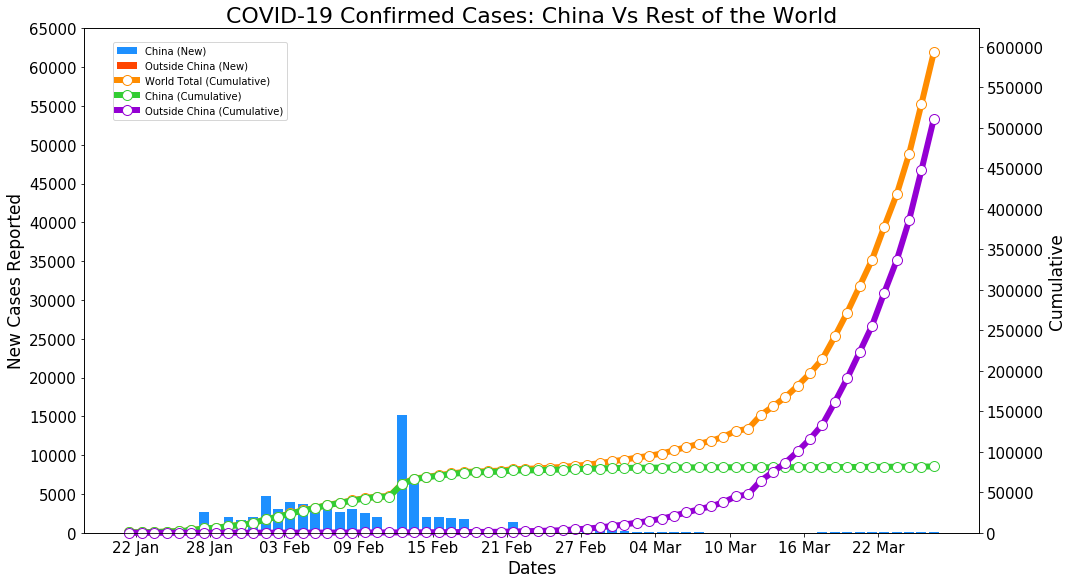

In [179]:
# Getting data for China and Oouside China
# df - Cumulative data for china, outside china and world total  (confirmed cases)
# df_newcases- new cases reported per day  (confirmed cases)
df_confirmed_report = df_confirmed.copy()
df_confirmed_report.loc[df_confirmed_report['country'] != "China","country"] = "Outside China"
df_confirmed_report = df_confirmed_report.groupby("country").sum().drop(["Lat","Long"],axis =1)
df_confirmed_report.loc["Total"] = df_confirmed_report.sum()
df_confirmed_newcases = df_confirmed_report.groupby(level =0).diff(axis =1)

f = plt.figure(figsize=(15,8))
ax1 = f.add_subplot(111)

ax1.bar(df_confirmed_report[df_confirmed_report.index == "China"].columns,df_confirmed_newcases[df_confirmed_newcases.index == "China"].values[0], label = "China (New)",color='dodgerblue')
ax1.bar(df_confirmed_report[df_confirmed_report.index == "Outside China"].columns,df_confirmed_newcases[df_confirmed_newcases.index == "Outside China"].values[0],bottom=df_confirmed_newcases[df_confirmed_newcases.index == "China"].values[0],label = "Outside China (New)",color='orangered')

# Labels
ax1.set_xlabel("Dates",fontsize=17)
ax1.set_ylabel("New Cases Reported",fontsize =17)

ax1.tick_params(labelsize=15)
ax1.set_xticks(np.arange(0.5, len(df_confirmed_report.columns), 6))
ax1.set_xticklabels([datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in df_confirmed_report.columns][::6],fontsize=15)
ax1.set_yticks(np.arange(0, df_confirmed_report.max(axis = 1)[2]/10+10000, 5000))
# ax1.spines['bottom'].set_position('zero')

ax2 = ax1.twinx()
marker_style = dict(linewidth=6, linestyle='-', marker='o',markersize=10, markerfacecolor='#ffffff')

ax2.plot(df_confirmed_report[df_confirmed_report.index == "Total"].columns ,df_confirmed_report[df_confirmed_report.index == "Total"].values[0],**marker_style,label = "World Total (Cumulative)",color="darkorange",clip_on=False)
ax2.plot(df_confirmed_report[df_confirmed_report.index == "China"].columns ,df_confirmed_report[df_confirmed_report.index == "China"].values[0],**marker_style,label = "China (Cumulative)",color="limegreen",clip_on=False)
ax2.plot(df_confirmed_report[df_confirmed_report.index == "Outside China"].columns ,df_confirmed_report[df_confirmed_report.index == "Outside China"].values[0],**marker_style,label ="Outside China (Cumulative)",color="darkviolet",clip_on=False)
ax2.bar([0],[0])

# Label
ax2.tick_params(labelsize=15)
ax2.set_ylabel("Cumulative",fontsize =17)
ax2.set_xticks(np.arange(0.5, len(df_confirmed_report.columns), 6))
ax2.set_xticklabels([datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in df_confirmed_report.columns][::6])
ax2.set_yticks(np.arange(0, df_confirmed_report.max(axis = 1)[2]+50000, 50000))

f.tight_layout()
f.legend(loc = "upper left", bbox_to_anchor=(0.1,0.95))
plt.title("COVID-19 Confirmed Cases: China Vs Rest of the World",fontsize = 22)
plt.savefig('China vs Rest of the world.png')
plt.show()

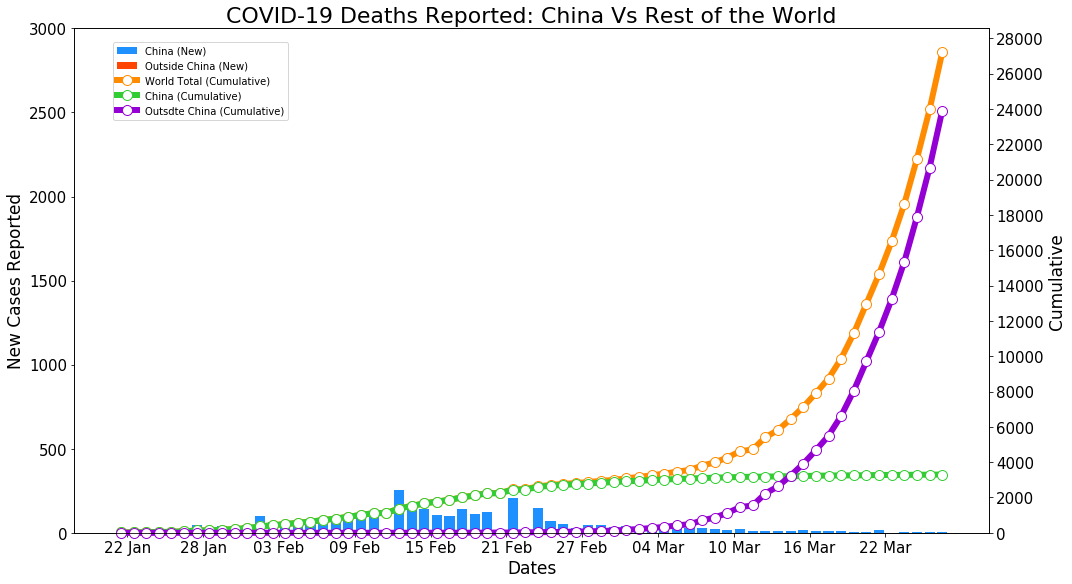

In [180]:
# Getting data for China and Oouside China
# df - Cumulative data for china, outside china and world total (deaths)
# df_newcases- new cases reported per day (deaths)
df_deaths_report = df_deaths.copy()
df_deaths_report.loc[df_deaths_report['country'] != "China","country"] = "Outside China"
df_deaths_report = df_deaths_report.groupby("country").sum().drop(["Lat","Long"],axis =1)
df_deaths_report.loc["Total"] = df_deaths_report.sum()
df_deaths_newcases = df_deaths_report.groupby(level =0).diff(axis =1)

f = plt.figure(figsize=(15,8))
ax1 = f.add_subplot(111)

ax1.bar(df_deaths_report[df_deaths_report.index == "China"].columns,df_deaths_newcases[df_deaths_newcases.index == "China"].values[0], label = "China (New)",color='dodgerblue')
ax1.bar(df_deaths_report[df_deaths_report.index == "Outside China"].columns,df_deaths_newcases[df_deaths_newcases.index == "Outside China"].values[0],bottom=df_deaths_newcases[df_deaths_newcases.index == "China"].values[0],label = "Outside China (New)",color='orangered')

# Labels
ax1.set_xlabel("Dates",fontsize=17)
ax1.set_ylabel("New Cases Reported",fontsize =17)

ax1.tick_params(labelsize=15)
ax1.set_xticks(np.arange(0.5, len(df_deaths_report.columns), 6))
ax1.set_xticklabels([datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in df_deaths_report.columns][::6],fontsize=15)
ax1.set_yticks(np.arange(0, df_deaths_report.max(axis = 1)[2]/10+500, 500))
# ax1.spines['bottom'].set_position('zero')

ax2 = ax1.twinx()
marker_style = dict(linewidth=6, linestyle='-', marker='o',markersize=10, markerfacecolor='#ffffff')

ax2.plot(df_deaths_report[df_deaths_report.index == "Total"].columns ,df_deaths_report[df_deaths_report.index == "Total"].values[0],**marker_style,label = "World Total (Cumulative)",color="darkorange",clip_on=False)
ax2.plot(df_deaths_report[df_deaths_report.index == "China"].columns ,df_deaths_report[df_deaths_report.index == "China"].values[0],**marker_style,label = "China (Cumulative)",color="limegreen",clip_on=False)
ax2.plot(df_deaths_report[df_deaths_report.index == "Outside China"].columns ,df_deaths_report[df_deaths_report.index == "Outside China"].values[0],**marker_style,label ="Outsdte China (Cumulative)",color="darkviolet",clip_on=False)
ax2.bar([0],[0])

# Label
ax2.tick_params(labelsize=15)
ax2.set_ylabel("Cumulative",fontsize =17)
ax2.set_xticks(np.arange(0.5, len(df_deaths_report.columns), 6))
ax2.set_xticklabels([datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in df_deaths_report.columns][::6])
ax2.set_yticks(np.arange(0, df_deaths_report.max(axis = 1)[2]+1000, 2000))

f.tight_layout()
f.legend(loc = "upper left", bbox_to_anchor=(0.1,0.95))
plt.title("COVID-19 Deaths Reported: China Vs Rest of the World",fontsize = 22)
plt.savefig('China vs Rest of the world1.png')
plt.show()

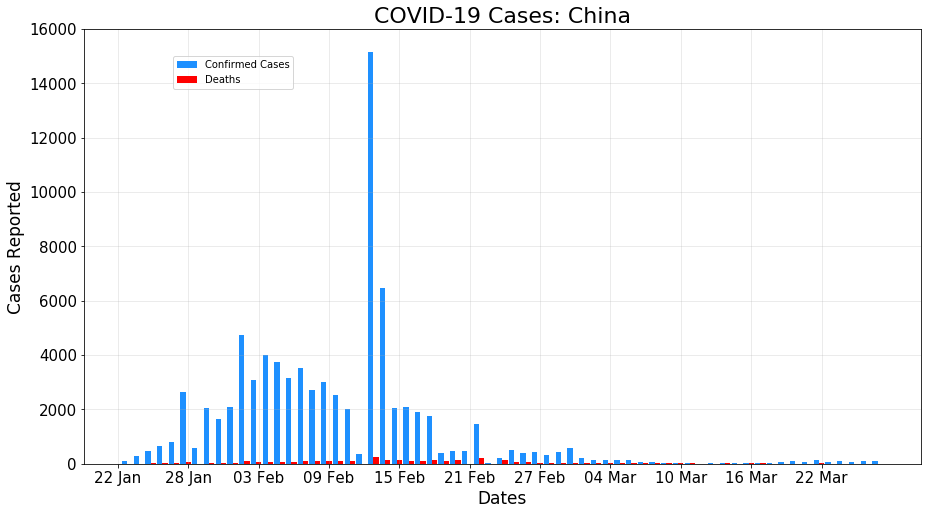

In [181]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(111)

ax.bar(0.05+np.arange(len(df_confirmed_newcases[df_confirmed_newcases.index == "China"].columns)),df_confirmed_newcases[df_confirmed_newcases.index == "China"].values[0], label = "Confirmed Cases",color='dodgerblue',width = 0.45)
ax.bar(0.5+np.arange(len(df_deaths_newcases[df_deaths_newcases.index == "China"].columns)),df_deaths_newcases[df_deaths_newcases.index == "China"].values[0], label = "Deaths",color='red',width = 0.45)
# ax.bar(0.67+np.arange(len(df_recovered_newcases[df_recovered_newcases.index == "China"].columns)),df_recovered_newcases[df_recovered_newcases.index == "China"].values[0], label = "Recoveries",color='orange',width = 0.33)

# ax.bar(df_recovered_report[df_recovered_report.index == "Outside China"].columns,df_newcases[df_newcases.index == "Outside China"].values[0],bottom=df_newcases[df_newcases.index == "China"].values[0],label = "Outside China (New)",color='orangered')

# Labels
ax.set_xlabel("Dates",fontsize=17)
ax.set_ylabel("Cases Reported",fontsize =17)

ax.tick_params(labelsize=15)
ax.set_xticks(np.arange(0.5, len(df_confirmed_newcases.columns), 6))
ax.set_xticklabels([datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in df_confirmed_newcases.columns][::6],fontsize=15)
ax.set_yticks(np.arange(0, df_confirmed_newcases.loc["China"].max()+2000, 2000))
ax.legend(loc = "upper left", bbox_to_anchor=(0.1,0.95))
plt.title("COVID-19 Cases: China",fontsize = 22)
plt.grid(alpha = 0.3)
plt.savefig('China vs Rest of the world3.png')
plt.show()

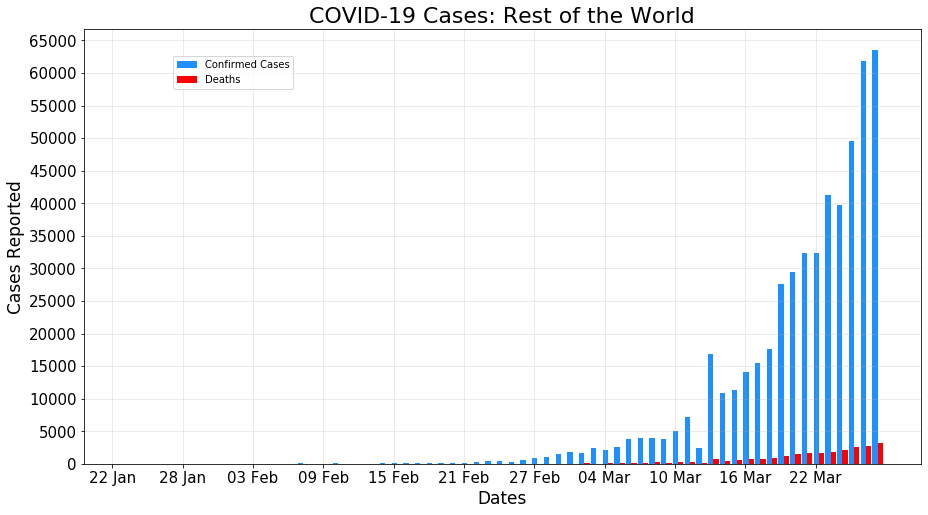

In [182]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(111)

ax.bar(0.05+np.arange(len(df_confirmed_newcases[df_confirmed_newcases.index == "Outside China"].columns)),df_confirmed_newcases[df_confirmed_newcases.index == "Outside China"].values[0], label = "Confirmed Cases",color='dodgerblue',width = 0.45)
ax.bar(0.5+np.arange(len(df_deaths_newcases[df_deaths_newcases.index == "Outside China"].columns)),df_deaths_newcases[df_deaths_newcases.index == "Outside China"].values[0], label = "Deaths",color='red',width = 0.45)
# ax.bar(0.67+np.arange(len(df_recovered_newcases[df_recovered_newcases.index == "Outside China"].columns)),df_recovered_newcases[df_recovered_newcases.index == "Outside China"].values[0], label = "Recoveries",color='orange',width = 0.33)

# ax.bar(df_recovered_report[df_recovered_report.index == "Outside China"].columns,df_newcases[df_newcases.index == "Outside China"].values[0],bottom=df_newcases[df_newcases.index == "China"].values[0],label = "Outside China (New)",color='orangered')

# Labels
ax.set_xlabel("Dates",fontsize=17)
ax.set_ylabel("Cases Reported",fontsize =17)

ax.tick_params(labelsize=15)
ax.set_xticks(np.arange(0, len(df_confirmed_newcases.columns), 6))
ax.set_xticklabels([datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in df_confirmed_newcases.columns][::6],fontsize=15)
ax.set_yticks(np.arange(0, df_confirmed_newcases.loc["Outside China"].max()+5000, 5000))
ax.legend(loc = "upper left", bbox_to_anchor=(0.1,0.95))
plt.title("COVID-19 Cases: Rest of the World",fontsize = 22)
plt.grid(alpha = 0.3)
plt.savefig('China vs Rest of the world4.png')
plt.show()

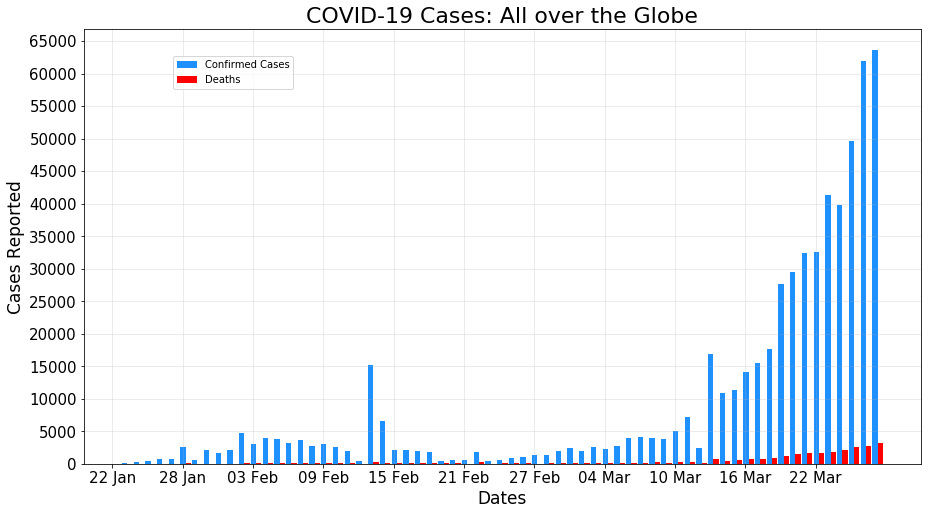

In [183]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(111)

ax.bar(0.05+np.arange(len(df_confirmed_newcases[df_confirmed_newcases.index == "Total"].columns)),df_confirmed_newcases[df_confirmed_newcases.index == "Total"].values[0], label = "Confirmed Cases",color='dodgerblue',width = 0.45)
ax.bar(0.5+np.arange(len(df_deaths_newcases[df_deaths_newcases.index == "Total"].columns)),df_deaths_newcases[df_deaths_newcases.index == "Total"].values[0], label = "Deaths",color='red',width = 0.45)
# ax.bar(0.67+np.arange(len(df_recovered_newcases[df_recovered_newcases.index == "Total"].columns)),df_recovered_newcases[df_recovered_newcases.index == "Total"].values[0], label = "Recoveries",color='orange',width = 0.33)

# ax.bar(df_recovered_report[df_recovered_report.index == "Outside China"].columns,df_newcases[df_newcases.index == "Outside China"].values[0],bottom=df_newcases[df_newcases.index == "China"].values[0],label = "Outside China (New)",color='orangered')

# Labels
ax.set_xlabel("Dates",fontsize=17)
ax.set_ylabel("Cases Reported",fontsize =17)

ax.tick_params(labelsize=15)
ax.set_xticks(np.arange(0, len(df_confirmed_newcases.columns), 6))
ax.set_xticklabels([datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in df_confirmed_newcases.columns][::6],fontsize=15)
ax.set_yticks(np.arange(0, df_confirmed_newcases.loc["Total"].max()+5000, 5000))
ax.legend(loc = "upper left", bbox_to_anchor=(0.1,0.95))
plt.title("COVID-19 Cases: All over the Globe",fontsize = 22)
plt.grid(alpha = 0.3)
plt.savefig('China vs Rest of the world5.png')
plt.show()

## COVID-19 : INDIA

In [184]:
india_data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
df_india = pd.io.json.json_normalize(india_data_json['data']['statewise'])
df_india = df_india.set_index("state")

In [185]:
total = df_india.sum()
total.name = "Total"
pd.DataFrame(total).transpose().style.background_gradient(cmap='Wistia',axis=1)

In [186]:
df_india.style.background_gradient(cmap='Wistia')

In [187]:
df_india[df_india['deaths'] > 0].style.background_gradient(cmap='Wistia')

In [188]:
df_india.corr().style.background_gradient(cmap='Reds')

In [189]:
locations = {
    "Kerala" : [10.8505,76.2711],
    "Maharashtra" : [19.7515,75.7139],
    "Karnataka": [15.3173,75.7139],
    "Telangana": [18.1124,79.0193],
    "Uttar Pradesh": [26.8467,80.9462],
    "Rajasthan": [27.0238,74.2179],
    "Gujarat":[22.2587,71.1924],
    "Delhi" : [28.7041,77.1025],
    "Punjab":[31.1471,75.3412],
    "Tamil Nadu": [11.1271,78.6569],
    "Haryana": [29.0588,76.0856],
    "Madhya Pradesh":[22.9734,78.6569],
    "Jammu and Kashmir":[33.7782,76.5762],
    "Ladakh": [34.1526,77.5770],
    "Andhra Pradesh":[15.9129,79.7400],
    "West Bengal": [22.9868,87.8550],
    "Bihar": [25.0961,85.3131],
    "Chhattisgarh":[21.2787,81.8661],
    "Chandigarh":[30.7333,76.7794],
    "Uttarakhand":[30.0668,79.0193],
    "Himachal Pradesh":[31.1048,77.1734],
    "Goa": [15.2993,74.1240],
    "Odisha":[20.9517,85.0985],
    "Andaman and Nicobar Islands": [11.7401,92.6586],
    "Puducherry":[11.9416,79.8083],
    "Manipur":[24.6637,93.9063],
    "Mizoram":[23.1645,92.9376],
    "Assam":[26.2006,92.9376],
    "Meghalaya":[25.4670,91.3662],
    "Tripura":[23.9408,91.9882],
    "Arunachal Pradesh":[28.2180,94.7278],
    "Jharkhand" : [23.6102,85.2799],
    "Nagaland": [26.1584,94.5624],
    "Sikkim": [27.5330,88.5122],
    "Dadra and Nagar Haveli":[20.1809,73.0169],
    "Lakshadweep":[10.5667,72.6417],
    "Daman and Diu":[20.4283,72.8397]    
}
df_india["Lat"] = ""
df_india["Long"] = ""
for index in df_india.index :
    df_india.loc[df_india.index == index,"Lat"] = locations[index][0]
    df_india.loc[df_india.index == index,"Long"] = locations[index][1]

In [190]:
# url = "https://raw.githubusercontent.com/Subhash9325/GeoJson-Data-of-Indian-States/master/Indian_States"
# state_json = requests.get(url).json()
india = folium.Map(location=[23,80], zoom_start=4,max_zoom=6,min_zoom=4,height=500,width="80%")
for i in range(0,len(df_india[df_india['confirmed']>0].index)):
    folium.Circle(
        location=[df_india.iloc[i]['Lat'], df_india.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_india.iloc[i].name+"</h5>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_india.iloc[i]['confirmed'])+"</li>"+
        "<li>Active:   "+str(df_india.iloc[i]['active'])+"</li>"+
        "<li>Recovered:   "+str(df_india.iloc[i]['recovered'])+"</li>"+
        "<li>Deaths:   "+str(df_india.iloc[i]['deaths'])+"</li>"+
        
        "<li>Mortality Rate:   "+str(np.round(df_india.iloc[i]['deaths']/(df_india.iloc[i]['confirmed']+1)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int(np.log2(df_india.iloc[i]['confirmed']+1)))*15000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(india)

india